#Modelo de clasificación: Procesado completo + PCA + Random Forest

El análisis de construcción de un modelo predictivo para nuestra tarea utiliza ahora un modelo de Random Forest con una descomposición por componentes previa. Se realiza un acercamiento experimental estableciendo unos parmétros adecuados para la descomposición a partir de los resultados de mejor estimador (Random Forest con 50 estimadores y profundidad máxima de 10)

##Instrucciones Generales

Para poder ejecutar el procesamiento propuesto, es necesario cargar tanto los archivos de la competencia de kaggle como el archivo de categorización manual de programas por área de conocimiento.

Para cargar los archivos de la competencia se puede:

1. Descargar directamente desde la página de kaggle: https://www.kaggle.com/competitions/udea-ai-4-eng-20251-pruebas-saber-pro-colombia/data y luego cargar manualmente al entorno

2. O ejecutar las celdas de carga directa utilizando una api-key propia de kaggle (archivo kaggle.json) que se debe cargar al entorno

Finalmente se debe cargar el archivo Categorias.csv que se ha enlazado en el repositorio github de esta solución para poder aplicar el procesamiento

##Importaciones básicas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
%matplotlib inline

##Preprocesado de los datos

###Carga de los datos

In [ ]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.09GB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


###Creacion dataframe y su transformación

####Definición de las funciones de transformación

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy

In [ ]:
def process_data(df, programs_df):

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

####Dataframe resultante

In [ ]:
try:
  df = pd.read_csv("train.csv")
except:
  print("No se ha cargado el archivo train.csv al entorno")

In [ ]:
try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
    programs_df = programs_df.sample(frac=0.70, random_state=42)
    df = process_data(df, programs_df)
    print(df.shape)
except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

/tmp/ipython-input-4-3166745170.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(692500, 59)


###Separación de los datos

In [ ]:
X = df.drop(columns=['RENDIMIENTO_GLOBAL', 'ESTU_PRGM_ACADEMICO'])
y = df['RENDIMIENTO_GLOBAL']
print(X.shape)
print(y.shape)

(692500, 57)
(692500,)


##Creación y evaluacion del modelo

###Split de los datos train: 70% - test: 30%

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)

###Modelo y calibración

In [ ]:
from sklearn.decomposition import PCA

n = Xtr.shape[1]
max_acc = 0
n_components = 4

for i in range(4,n,6):

  pca = PCA(n_components=i)
  pca.fit(Xtr)
  Xtr_pca = pca.transform(Xtr)
  Xts_pca = pca.transform(Xts)
  rf = RandomForestClassifier(n_estimators=50, max_depth=10)
  rf.fit(Xtr_pca,ytr)
  acc_tr = rf.score(Xtr_pca,ytr)
  acc_ts = rf.score(Xts_pca,yts)

  if acc_ts > max_acc:
    max_acc = acc_ts
    n_components = i

  print (f"""model with a PCA decomposition into
          {i} components and random forest with 50x10 estimators - max depth,
          {acc_tr:6f},{acc_ts:6f}""")


model with a PCA decomposition into
          4 components and random forest with 50x10 estimators - max depth,
          0.392437,0.378209
model with a PCA decomposition into
          10 components and random forest with 50x10 estimators - max depth,
          0.411915,0.393372
model with a PCA decomposition into
          16 components and random forest with 50x10 estimators - max depth,
          0.419711,0.399812
model with a PCA decomposition into
          22 components and random forest with 50x10 estimators - max depth,
          0.423750,0.401921
model with a PCA decomposition into
          28 components and random forest with 50x10 estimators - max depth,
          0.430624,0.405256
model with a PCA decomposition into
          34 components and random forest with 50x10 estimators - max depth,
          0.433960,0.406941
model with a PCA decomposition into
          40 components and random forest with 50x10 estimators - max depth,
          0.434960,0.406806
model with a P

####Refinando la descomposición optima

In [ ]:
max_acc = 0

for i in range(n_components-3,min(n_components+4, Xtr.shape[1])):

  pca = PCA(n_components=i)
  pca.fit(Xtr)
  Xtr_pca = pca.transform(Xtr)
  Xts_pca = pca.transform(Xts)
  rf = RandomForestClassifier(n_estimators=50, max_depth=10)
  rf.fit(Xtr_pca,ytr)

  acc_tr = rf.score(Xtr_pca,ytr)
  acc_ts = rf.score(Xts_pca,yts)

  if acc_ts > max_acc:
    max_acc = acc_ts
    n_components = i

  print (f"""model with a PCA decomposition into
          {i} components and random forest with 50x10 estimators - max depth,
          train accuracy: {acc_tr:6f}, test accuracy: {acc_ts:6f}""")

model with a PCA decomposition into
          43 components and random forest with 50x10 estimators - max depth,
          train accuracy: 0.433250, test accuracy: 0.407543
model with a PCA decomposition into
          44 components and random forest with 50x10 estimators - max depth,
          train accuracy: 0.432035, test accuracy: 0.407167
model with a PCA decomposition into
          45 components and random forest with 50x10 estimators - max depth,
          train accuracy: 0.431165, test accuracy: 0.406075
model with a PCA decomposition into
          46 components and random forest with 50x10 estimators - max depth,
          train accuracy: 0.431752, test accuracy: 0.406527
model with a PCA decomposition into
          47 components and random forest with 50x10 estimators - max depth,
          train accuracy: 0.431810, test accuracy: 0.406344
model with a PCA decomposition into
          48 components and random forest with 50x10 estimators - max depth,
          train accura

In [ ]:
print(f"Descomposición optima con {n_components}")

Descomposición optima con 43


Parece ser que la descomposición optima para la combinación es aquella que usa 43 componentes

####Validación cruzada

In [ ]:
def bootstrap_score(X, y, test_size, iterations=5):
  trscores, tsscores = [], []
  for _ in range(iterations):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    pca = PCA(n_components=43)
    pca.fit(Xtr)
    Xtr = pca.transform(Xtr)
    Xts = pca.transform(Xts)
    rf = RandomForestClassifier(n_estimators=50, max_depth=10)
    rf.fit(Xtr,ytr)
    trscores.append(rf.score(Xtr, ytr))
    tsscores.append(rf.score(Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

def evaluate_model(df, test_size):
  sample_sizes = [int(i*df.shape[0]) for i in np.linspace(0.2, 1, 5)]
  tr_scores, ts_scores = [], []

  for sample_size in sample_sizes:
    X = df.sample(sample_size)
    y = X['RENDIMIENTO_GLOBAL']
    X = X.drop(columns=['RENDIMIENTO_GLOBAL', 'ESTU_PRGM_ACADEMICO'])
    tr_sc, ts_sc = bootstrap_score(X, y, test_size, iterations=3)
    tr_scores.append(tr_sc)
    ts_scores.append(ts_sc)

  return (tr_scores, ts_scores)

def plot_learning_curve(title, train_scores_mean, train_scores_std,
                        test_scores_mean, test_scores_std, ylim=None,
                        train_sizes=np.linspace(.2, 1.0, 5)):

    from matplotlib import pyplot as plt

    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="test score")

    plt.legend(loc="best")

def compute_and_plot_learning_curve(test_size, title="Random Forest"):

    learn_curve_data = evaluate_model(df, 0.3)
    tr_means = np.array([learn_curve_data[0][i][0] for i in range(len(learn_curve_data[0]))])
    tr_stds = np.array([learn_curve_data[0][i][1] for i in range(len(learn_curve_data[0]))])
    ts_means = np.array([learn_curve_data[1][i][0] for i in range(len(learn_curve_data[1]))])
    ts_stds = np.array([learn_curve_data[1][i][1] for i in range(len(learn_curve_data[1]))])

    sample_sizes = [int(i*df.shape[0]) for i in np.linspace(0.2, 1, 5)]

    plot_learning_curve(title, tr_means, tr_stds, ts_means, ts_stds, train_sizes=sample_sizes)

In [ ]:
tr_sc, ts_sc = bootstrap_score(X, y, 0.3)
print(f"Train accuracy {tr_sc[0]:6f} ± {tr_sc[1]:6f}, test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

Train accuracy 0.433494 ± 0.000720, test accuracy: 0.406902 ± 0.000717


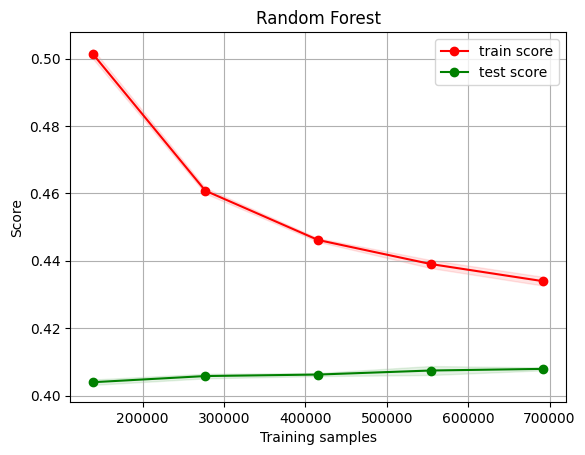

In [ ]:
compute_and_plot_learning_curve(0.30)

###Calibración con todo el conjunto de datos

In [ ]:
pca = PCA(n_components=43)
pca.fit(X)
X = pca.transform(X)
rf = RandomForestClassifier(n_estimators=50, max_depth=10)
rf.fit(X,y)

RandomForestClassifier(max_depth=10, n_estimators=50)

##Predicción

In [ ]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df_processed = process_data(test_df, programs_df)
print(test_df_processed.shape)
test_df_processed = test_df_processed.drop(columns=['ESTU_PRGM_ACADEMICO'])

(296786, 20)


/tmp/ipython-input-4-3166745170.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(296786, 58)


In [ ]:
X = pca.transform(test_df_processed)
y_pred = rf.predict(X)

###Dataframe de predicción

In [ ]:
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
y_pred = pd.DataFrame(y_pred, columns=['RENDIMIENTO_GLOBAL'])
y_pred = y_pred.replace(dict(zip(range(4), grades)))
y_pred.head()
prediction_df = pd.concat([test_df['ID'], y_pred], axis=1).set_index('ID')
print(prediction_df.shape)
prediction_df.head()

(296786, 1)


,RENDIMIENTO_GLOBAL
ID,
550236,medio-alto
98545,medio-bajo
499179,alto
782980,bajo
785185,bajo


###Exportando el archivo

In [ ]:
prediction_df.to_csv("submission.csv")